In [47]:
import numpy as np

CSI = np.load('CSI0.npy')

(Nrx, Ntx, Nsc, Nt) = CSI.shape
print(Nrx, Ntx, Nsc, Nt)

fstart = 5300.0 * 1e6
fend = 5336.25 * 1e6
Tdur = 30.059486

# fs = (fend + fstart) / 2
fs = Nt / Tdur
BPMresol = 0.1
resol = BPMresol / 60 # 要分辨出0.1BPM，需要的频率分辨率
Ndft = int(fs / resol) # DFT点数
print(Ndft)

breathEnd = 0.7 # 呼吸最高频率
dftSize = int(breathEnd / resol) # DFT宽度
print(dftSize)

3 1 30 1500
29940
419


In [48]:
H = np.zeros((Nrx, Ntx, Nsc, dftSize), dtype = complex) # 用于存储DFT结果

m, n = np.meshgrid(np.arange(Nt), np.arange(dftSize))
Wdft = np.exp(-1j * 2 * np.pi * m * n / Ndft) # dft 矩阵

# print(Wdft)

print(Wdft.shape)
print(CSI[0][0][0].shape)

Hs = np.zeros((dftSize), dtype = complex)

for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            H[rx][tx][sc] = Wdft @ CSI[rx][tx][sc]
            Hs += H[rx][tx][sc]
                # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fstart * t / 312.5)
                # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fend * t / 312.5)

# H000 = np.fft.fft(CSI[0][0][0], Ndft)
# for rx in range(Nrx):
#     for tx in range(Ntx):
#         for sc in range(Nsc):
#             H[rx][tx][sc] = np.fft.fft(CSI[rx][tx][sc], Ndft)
            # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fstart * t / 312.5)
            # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fend * t / 312.5)


(419, 1500)
(1500,)


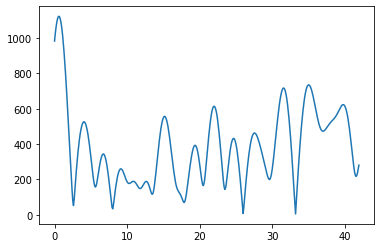

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

# breathStartHz = 0.16
# breathEndHz = 0.5

# plt.plot(np.abs(H000[:30]))
# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(H[0][0][2]))
plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(Hs))
# plt.plot(np.abs(CSI[0][0][0]))


[34.9 31.5 39.6 21.9 15.1 27.5 24.6 19.3  6.7  5.   9.1 10.8 12.6]


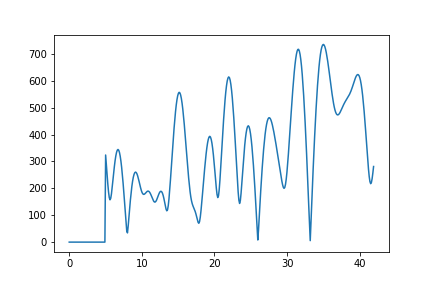

In [52]:
%matplotlib widget
from scipy.signal import find_peaks
filteredHs = np.zeros_like(Hs)
minBPM, maxBPM = 5, 50
minIndex, maxIndex = int(minBPM / BPMresol), int(maxBPM / BPMresol)

filteredHs[minIndex: maxIndex] = Hs[minIndex:maxIndex]

plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(filteredHs))
np.argmax(np.abs(filteredHs)) * BPMresol
idx, _ = find_peaks(np.abs(filteredHs), height = 0.1, distance = 1)

highestPeak = np.argsort(-np.abs(filteredHs[idx]))

print(idx[highestPeak] * BPMresol)

In [54]:
%matplotlib widget
from scipy.signal import find_peaks
filteredHs = np.zeros_like(Hs)
minBPM, maxBPM = 10, 30
minIndex, maxIndex = int(minBPM / BPMresol), int(maxBPM / BPMresol)

Amp = 0
WeightedSum = 0

for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            filteredHs = np.zeros_like(Hs, dtype=np.float64)
            filteredHs[minIndex: maxIndex] = np.abs(H[rx][tx][sc][minIndex:maxIndex])
            idx, _ = find_peaks(filteredHs, height = 0.1, distance = 1)
            highestPeak = np.argsort(-filteredHs[idx])
            Amp += filteredHs[idx[highestPeak[0]]]
            WeightedSum += filteredHs[idx[highestPeak[0]]] * idx[highestPeak[0]]
            Amp += filteredHs[idx[highestPeak[1]]]
            WeightedSum += filteredHs[idx[highestPeak[1]]] * idx[highestPeak[1]]
            Amp += filteredHs[idx[highestPeak[2]]]
            WeightedSum += filteredHs[idx[highestPeak[2]]] * idx[highestPeak[2]]

f = WeightedSum / Amp
f * BPMresol

# filteredHs[minIndex: maxIndex] = H[0][0][0][minIndex:maxIndex]

# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(filteredHs))
# np.argmax(np.abs(filteredHs)) * BPMresol
# idx, _ = find_peaks(np.abs(filteredHs), height = 0.1, distance = 1)

# highestPeak = np.argsort(-np.abs(filteredHs[idx]))

# print(idx[highestPeak] * BPMresol)

28.371109488886862

15.514653774873409

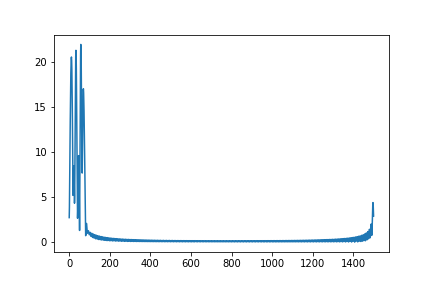

In [14]:
%matplotlib widget
filteredHs
s = np.fft.ifft(filteredHs, Nt)
abss = np.abs(s)
plt.plot(abss)

# get angle of s
angle = np.angle(s)

idx, _ = find_peaks(abss, height = 0.1, distance = 1)
slope = (abss[idx[0]] - abss[0]) / idx[0]
slope / (2 * np.pi) * 60